In [1]:
import pandas as pd
df = pd.read_csv('data/preTag_df.csv')
df

,review_text
0,ye be pretty good
1,the game have not crash on I do not know what ...
2,good cod since boy . come from a cod meet the ...
3,I like the game because I be a big cod fan eve...
4,just hit ll 55 in 18 horse it fun . yes it goo...
...,...
70118,bad cod ever 110
70119,in a long term call of duty player . play thou...
70120,good cod in the last 4 year
70121,may multiplayer mostly good some map be ass . ...


In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob

# split text into sentences and flatten
sentences = [str(x).split('.') for x in df.review_text]
sentences = [item for sublist in sentences for item in sublist]

# Extract aspects and descriptors
# Modified from https://towardsdatascience.com/aspect-based-sentiment-analysis-using-spacy-textblob-4c8de3e0d2b9
aspects = []
for sentence in sentences:
  doc = nlp(sentence)
  descriptors = ''
  target = ''
  for token in doc:
    if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
      target = token.text
    if token.pos_ == 'ADJ':
      prepend = ''
      for child in token.children:
        if child.pos_ != 'ADV':
          continue
        prepend += child.text + ' '
      descriptors = prepend + token.text
  aspects.append({'aspect': target,'description': descriptors})

# remove entries with blank aspect or descriptor
aspects = [x for x in aspects if x['aspect']!='' and x['description']!='']

# Add sentiment polarity scores
for aspect in aspects:
  aspect['sentiment'] = TextBlob(aspect['description']).sentiment.polarity

tag_df = pd.DataFrame(aspects)
display(tag_df.sort_values(by='sentiment',ascending=False).head(10))

,aspect,description,sentiment
24103,experience,perfect,1.0
1290,tt,perfect,1.0
5993,movement,awesome,1.0
18458,game,awesome,1.0
41138,duty,awesome,1.0
15670,multiplayer,perfect,1.0
11294,graphic,really awesome,1.0
16536,installment,excellent,1.0
16530,team,awesome,1.0
41131,soundeffect,awesome,1.0


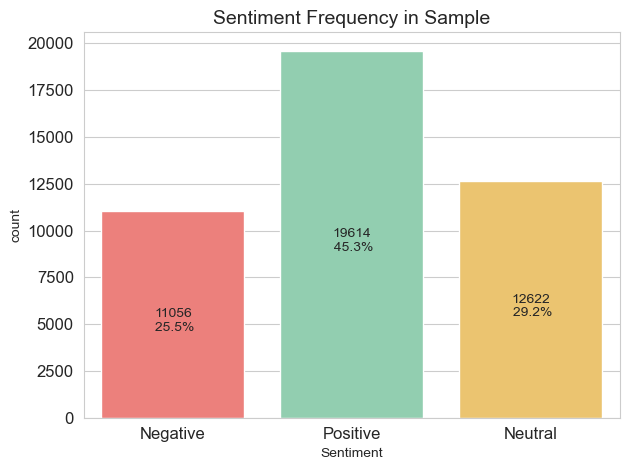

In [3]:
import numpy as np
tag_df['Sentiment'] = np.select([(tag_df['sentiment']>0),(tag_df['sentiment']<0),(tag_df['sentiment']==0)],['Positive','Negative','Neutral'])

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
ax=sns.countplot(data=tag_df,
              x="Sentiment", 
              palette = ['#FF6F69','#88D8B0','#ffcc5c'])
# add % annotations
for c in ax.containers:
    labels = [f'\n\n {h/tag_df.Sentiment.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.bar_label(ax.containers[0], label_type='center')
plt.title('Sentiment Frequency in Sample',fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show();

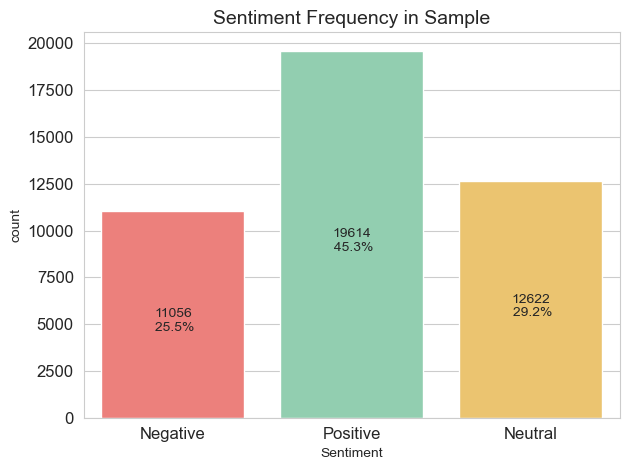

In [4]:
import numpy as np
tag_df['Sentiment'] = np.select([(tag_df['sentiment']>0),(tag_df['sentiment']<0),(tag_df['sentiment']==0)],['Positive','Negative','Neutral'])

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
ax=sns.countplot(data=tag_df,
              x="Sentiment", 
              palette = ['#FF6F69','#88D8B0','#ffcc5c'])
# add % annotations
for c in ax.containers:
    labels = [f'\n\n {h/tag_df.Sentiment.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
ax.bar_label(ax.containers[0], label_type='center')
plt.title('Sentiment Frequency in Sample',fontsize=14)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show();




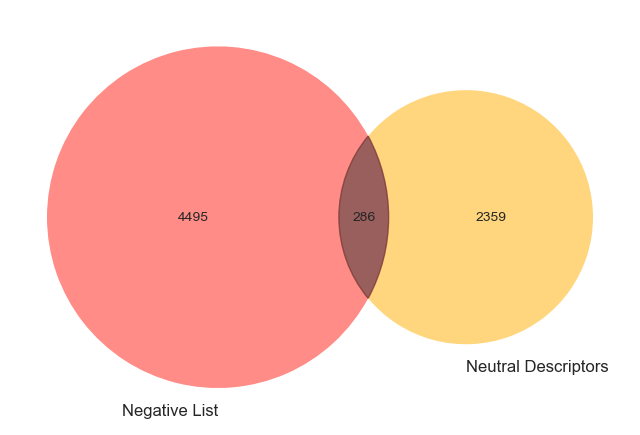

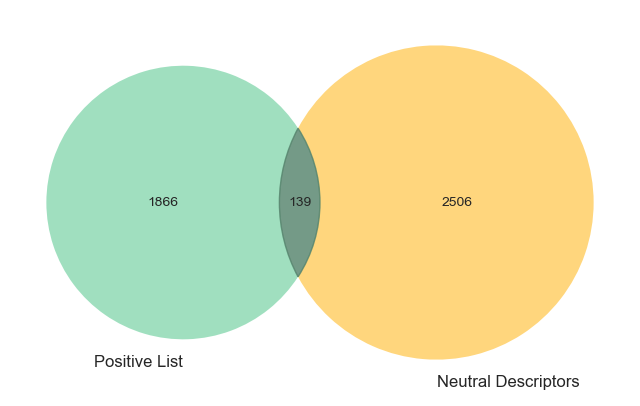

In [5]:
# set negative word list
negList=list(pd.read_csv("data/negList.csv")['Negative'])

# create Venn
from matplotlib_venn import venn2, venn2_circles
plt.figure(figsize=(8,8))
v=venn2([set(negList), set(tag_df[tag_df['sentiment']==0]['description'])],
        set_labels = ("Negative List", "Neutral Descriptors"),
        set_colors = ("#FF6F69","#ffcc5c"),
        alpha = 0.8)
v.get_patch_by_id('11').set_color("#7f3734")

# set positive word list
posList=list(pd.read_csv("data/posList.csv")['Positive'])

# create Venn
plt.figure(figsize=(8,8))
v=venn2([set(posList), set(tag_df[tag_df['sentiment']==0]['description'])],
        set_labels = ("Positive List", "Neutral Descriptors"),
        set_colors = ("#88D8B0","#ffcc5c"),
        alpha = 0.8)
v.get_patch_by_id('11').set_color("#518169")

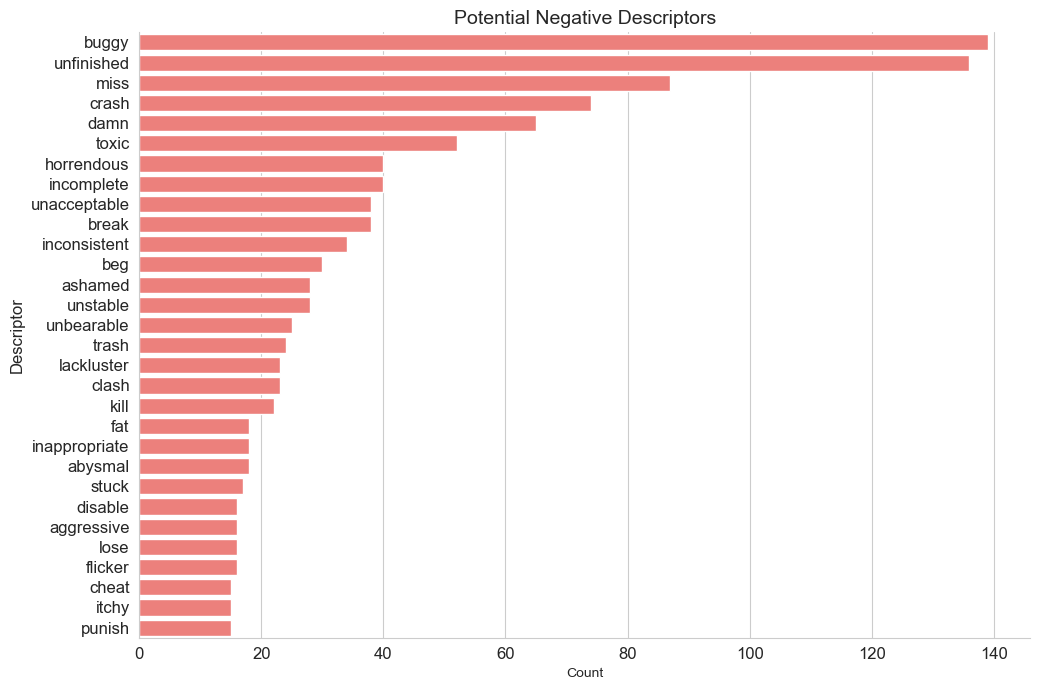

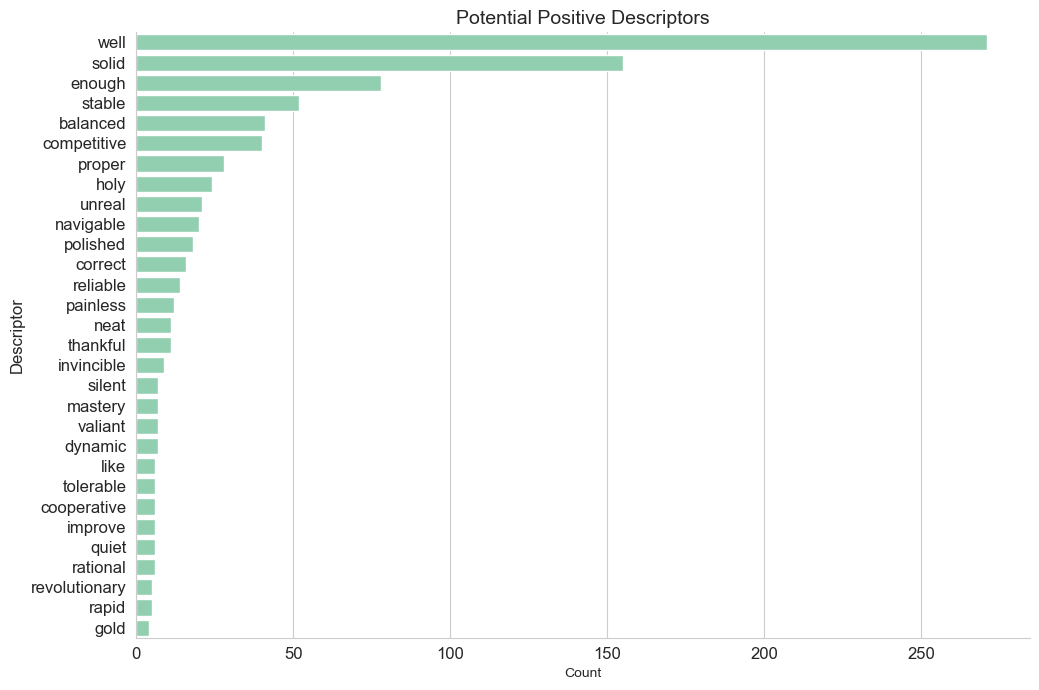

In [6]:
# create df of neutral descriptors contained in negative list
# negative list from https://gist.github.com/mkulakowski2/4289441
df1 = tag_df[(tag_df['sentiment']==0) & (tag_df['description'].isin(negList))]

# plot negative terms
ax=sns.catplot(data=df1.groupby('description',as_index=False)['aspect'].count().rename(columns={'aspect':'Count'}).sort_values(by='Count',ascending=False).head(30),
            kind='bar',
            y="description",
            x='Count',
            palette = ['#FF6F69'],
            height=7,
            aspect = 1.5)
plt.title('Potential Negative Descriptors',fontsize=14)
plt.tick_params(labelsize=12)
plt.ylabel('Descriptor',fontsize=12)
plt.tight_layout()
plt.show();

# create df of neutral descriptors contained in positive list
# positive list from https://gist.github.com/mkulakowski2/4289437
df2 = tag_df[(tag_df['sentiment']==0) & (tag_df['description'].isin(posList))]

# plot positive terms
ax=sns.catplot(data=df2.groupby('description',as_index=False)['aspect'].count().rename(columns={'aspect':'Count'}).sort_values(by='Count',ascending=False).head(30),
            kind='bar',
            y="description",
            x='Count',
            palette = ['#88D8B0'],
            height=7,
            aspect=1.5)
plt.title('Potential Positive Descriptors',fontsize=14)
plt.tick_params(labelsize=12)
plt.ylabel('Descriptor',fontsize=12)
plt.tight_layout()
plt.show();

In [7]:
# write to csv
tag_df.to_csv('data/tag_df.csv',index=False)